In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

**Does competing sites ever lead to bad signal?**

Let's re-do the case study on simple repression by lacI. This time, instead of placing the lacI binding site downstream of the RNAP binding site, we place the lacI binding site at the -10 binding site of RNAP

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [4]:
original_rep_site = 'AATTGTGAGCGGATAACAATT'
print('The length of the original repressor binding site is {}.'.format(len(original_rep_site)))

The length of the original repressor binding site is 21.


In [5]:
# Alternative repressor binding site
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

## Find the transcription start site
df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [6]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)
rep_emat = rnap_emat[(len(rnap_site) - len(original_rep_site)):, :]

### Making information footprint

First we assume that the LacI repressor has the exact same energy matrix as the RNA polymerase.

In [7]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

In [8]:
nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=0)
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)

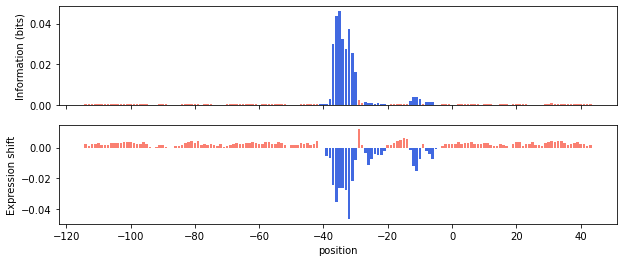

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4),
                       sharex=True)
ax1, ax2 = axes

ax1.set_ylabel('Information (bits)')
ax2.set_ylabel('Expression shift')
ax2.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax1.bar(x, footprint, edgecolor=None, color=shiftcolors)
ax2.bar(x, exshift_list, edgecolor=None, color=shiftcolors)
#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
n_NS = len(genome)
ep_wt, er_wt = -5, -10
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

In [11]:
nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=0)
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)

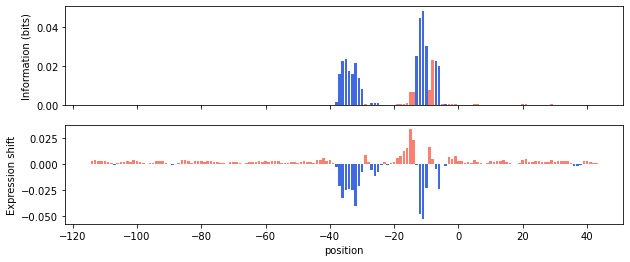

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4),
                       sharex=True)
ax1, ax2 = axes

ax1.set_ylabel('Information (bits)')
ax2.set_ylabel('Expression shift')
ax2.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax1.bar(x, footprint, edgecolor=None, color=shiftcolors)
ax2.bar(x, exshift_list, edgecolor=None, color=shiftcolors)
#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

### Engineering an energy matrix for the repressor that is different than the RNAP energy matrix but preserve the sequence specificity

In [2]:
def generate_emap(seq, max_mut_energy):
    nt_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    emat = np.zeros((4, len(seq)))
    for i,nt in enumerate(seq):
        for j in range(4):
            if j != nt_index[nt]:
                emat[j, i] = np.random.uniform(low=0.1, high=max_mut_energy)
    
    return emat

In [3]:
def plot_footprint(df, wtseq, rnap_wtseq, rep_wtseq):
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']

    nbins = 2
    upper_bound = np.mean(mu_data)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=0)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)

    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_xlabel('position')
    ax.set_ylabel('Mutual information (bits)')

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)
    ax.axvspan(rnap_start-116, rnap_end-116, alpha=0.5, color='#A9BFE3')
    ax.axvspan(rep_start-116, rep_end-116, alpha=0.5, color='#E8B19D')

    windowsize = 3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
    ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

    plt.show()

In [4]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

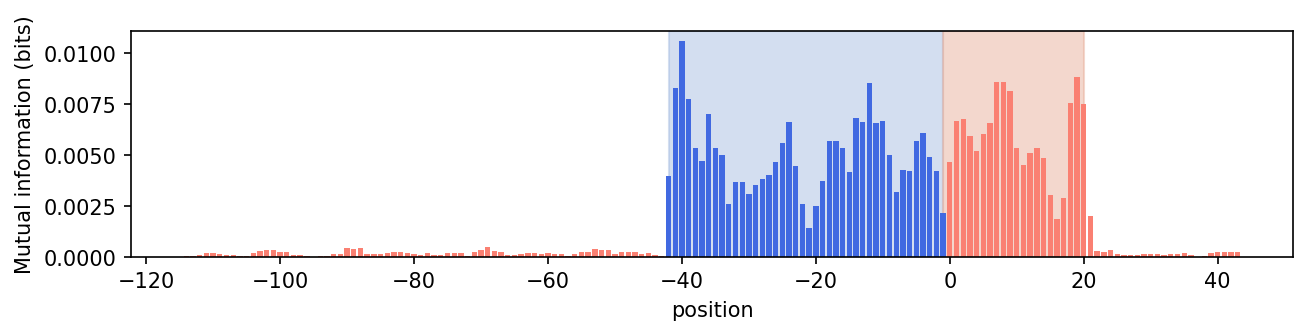

In [5]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
original_rep_site = 'AATTGTGAGCGGATAACAATT'

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(original_rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, original_rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, original_rep_site)

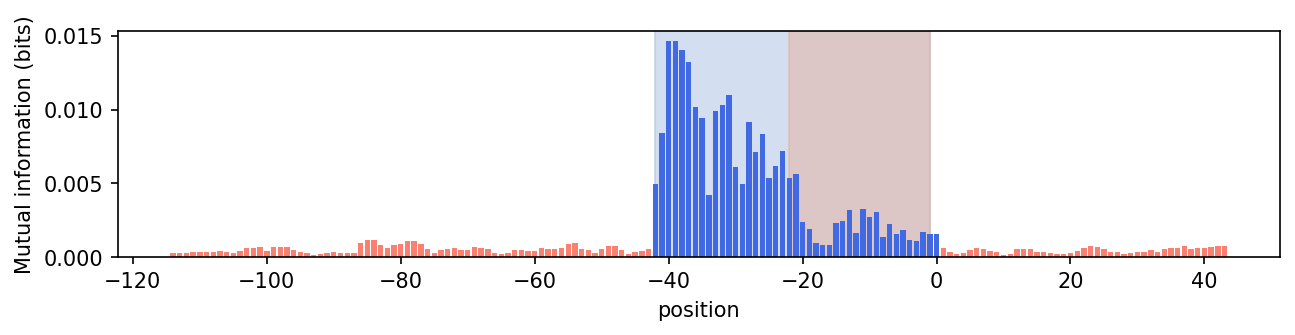

In [6]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 2)
rep_emat = rnap_emat[:, (len(rnap_site) - len(original_rep_site)):]

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

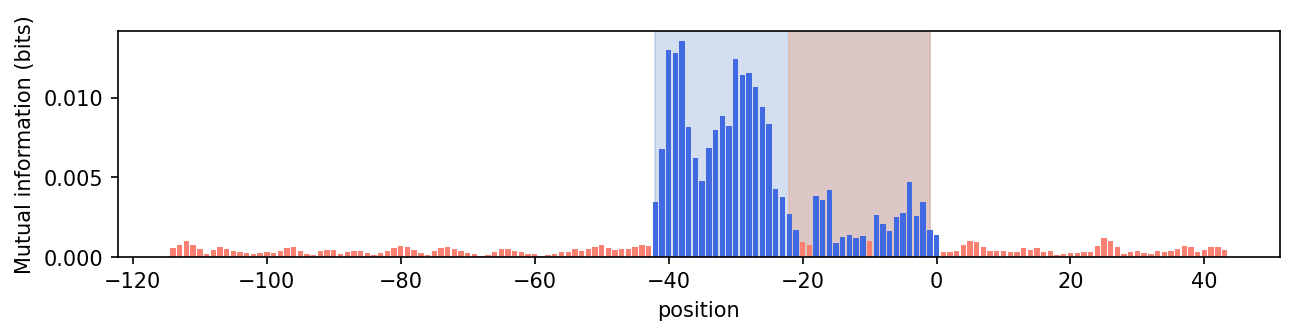

In [7]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 2)
rep_emat = generate_emap(rep_site, 2)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

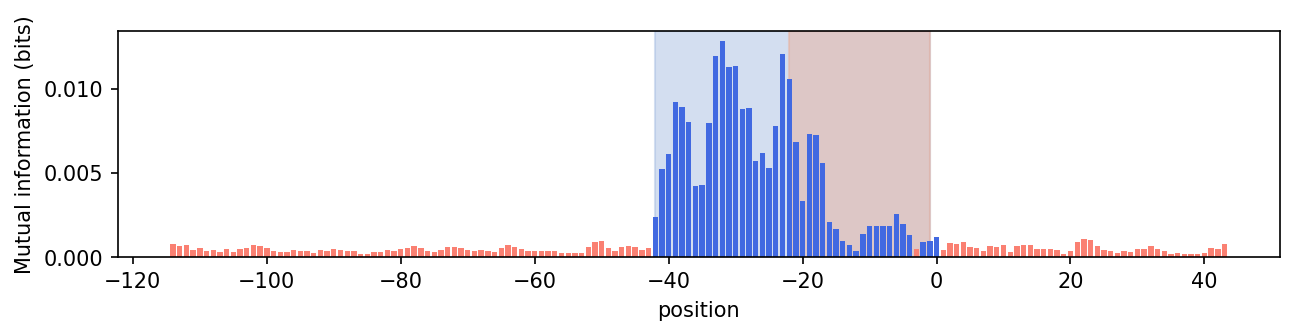

In [8]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 2)
rep_emat = generate_emap(rep_site, 2)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

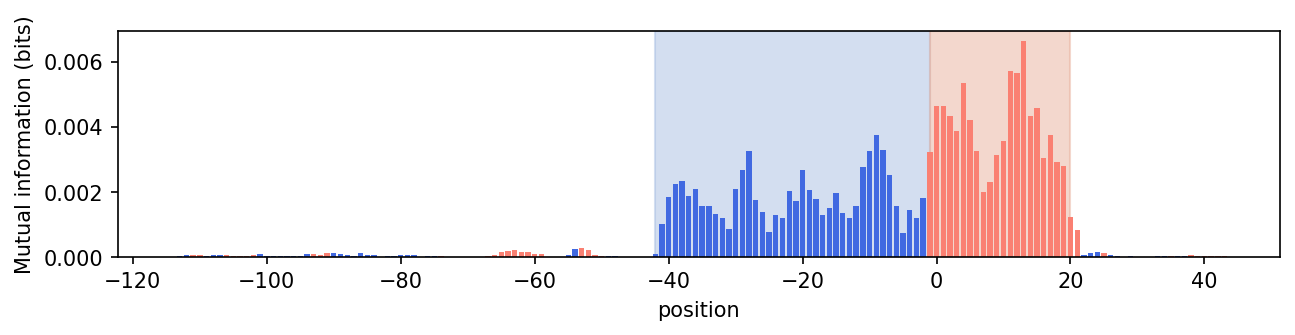

In [9]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(original_rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 500

df = tregs.simulate.simrep(promoter, rnap_site, original_rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, original_rep_site)

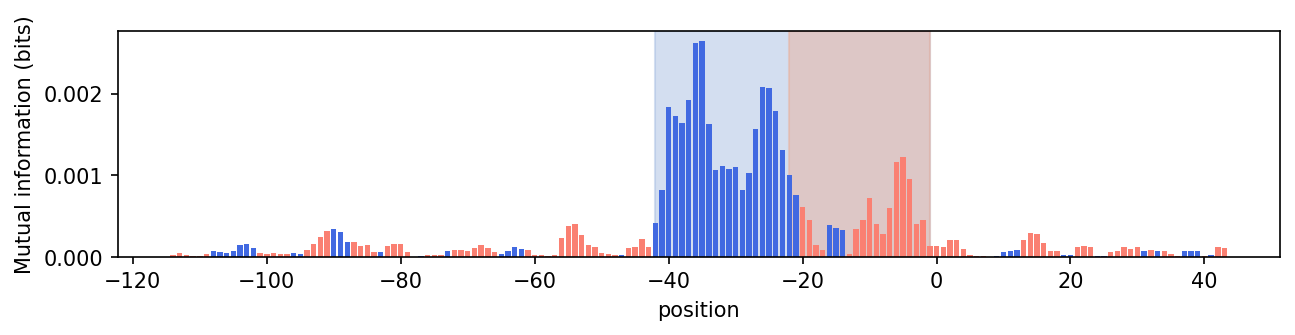

In [10]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 500

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

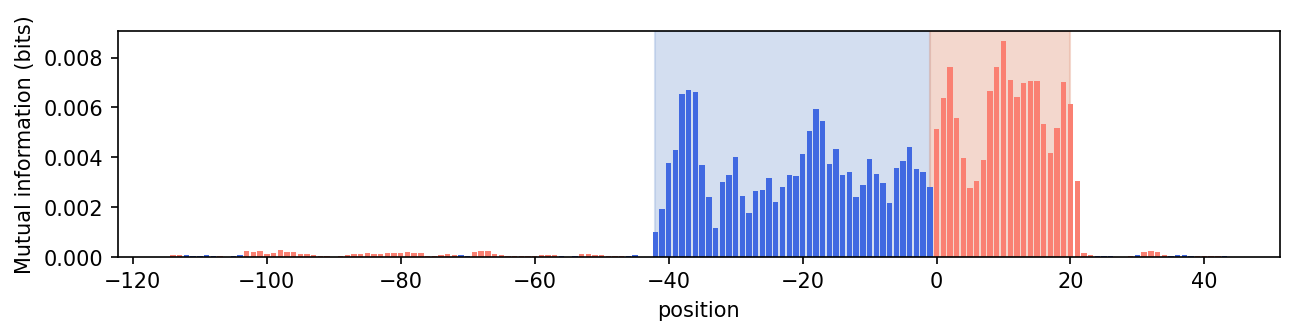

In [11]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(original_rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -17
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, original_rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, original_rep_site)

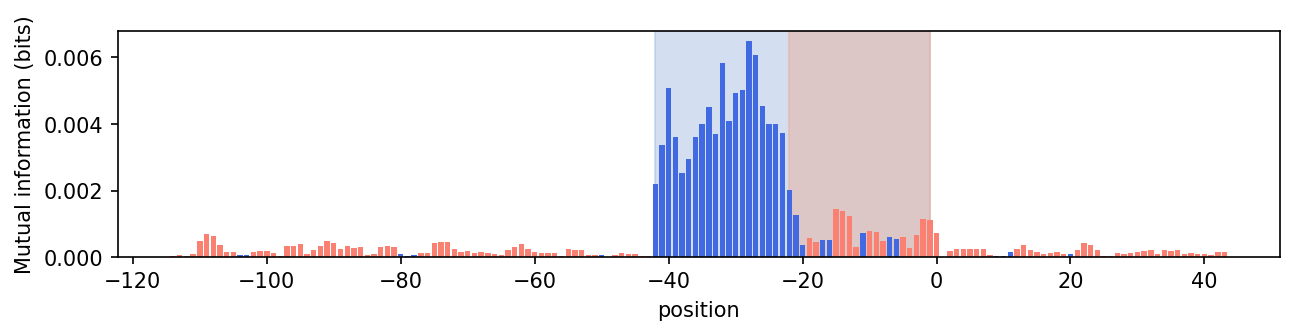

In [12]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -17
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)

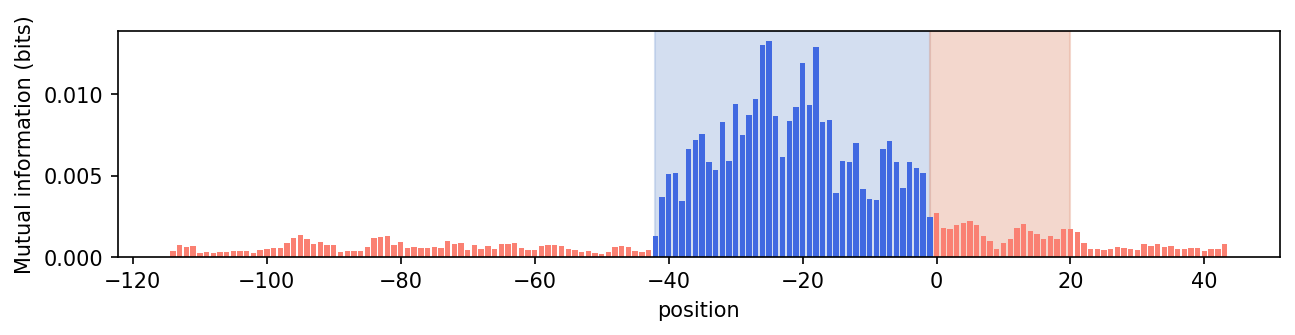

In [14]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(original_rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -12
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, original_rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, original_rep_site)

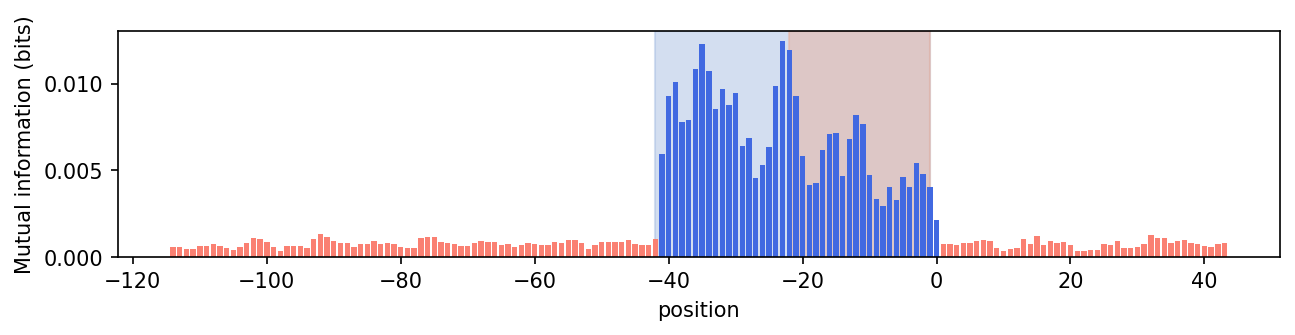

In [15]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = rnap_site[(len(rnap_site) - len(original_rep_site)):]

rnap_emat = generate_emap(rnap_site, 1)
rep_emat = generate_emap(rep_site, 1)

n_NS = len(genome)
ep_wt, er_wt = -5, -12
n_p = 4600
n_r = 15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)

plot_footprint(df, promoter, rnap_site, rep_site)